In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt

from neurodsp.spectral import compute_spectrum

from timescales.fit import convert_knee_val
from timescales.sim import sim_spikes_synaptic
from timescales.utils import create_windows, get_distinct_windows

### Modified Lorentzian

This notebook adds a modified Lorentzian, specifically the addition of a constant, that allows tapering to a constant power at high frequencies. This is commonly found in spike trains (real and simulated) and in autoregressive estimates of PSD.

This removes the guess work when deciding on a spike bin size. Before, binning or narrowing in on a frequency range was required to ignore the tapered tail of the PSD.

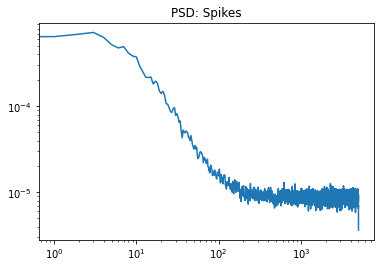

In [2]:
np.random.seed(0)
n_seconds = 100
fs = 10000
tau = convert_knee_val(10)

_, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1)
freqs, powers = compute_spectrum(spikes, fs)

plt.title('PSD: Spikes')
plt.loglog(freqs, powers);


In [3]:
def fit_lorentzian(freqs, powers, guess=None, bounds=None):
    
    if bounds is None:
        bounds = [
            [0,   0, -10, 0],
            [3, 100,  10, 10]
        ]
    if guess is None:
        guess = [2, 1, 0, 0]
    
    params, _ = curve_fit(lorentzian, freqs, np.log10(powers),
                          p0=guess, bounds=bounds)
    
    return params

    
def lorentzian(xs, exp, knee, b, c):
    
    return np.log10(10**b * (1 / (knee**(exp) + xs**(exp))) + c)

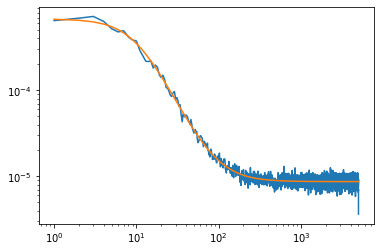

In [4]:
params = fit_lorentzian(freqs[1:], powers[1:])

plt.figure(1)
plt.loglog(freqs[1:], powers[1:])
plt.loglog(freqs[1:], 10**lorentzian(freqs[1:], *params))

In [5]:
print('Simulated Knee Freq: ', 10)
print('Estimated Knee Freq: ', params[1])

Simulated Knee Freq:  10
Estimated Knee Freq:  10.242814396539467


### Real Data

In [6]:
# Load data
dir_path = '/home/rph/Projects/timescale-methods/fcx1/20140526_277um'
subtype_dict = loadmat(f'{dir_path}/20140526_277um_SSubtypes.mat')

fs = 20000
n_seconds = 14000
times = np.arange(0, n_seconds, 1/fs)

spikes = subtype_dict['Si_CellFormat'][0][2][:, 0]
spikes = spikes * fs
spikes = spikes.astype(int)

# Extract behavioral data
beh_file = f'{dir_path}/20140526_277um_WSRestrictedIntervals.mat'

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

# Window by trial type
win_len = int(2*fs)
win_spacing = int(2*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

In [7]:
subtype = subtype_dict['Se_CellFormat'][0]

bin_size = 1

start_end = np.vstack((wake_starts, wake_ends)).T

powers = np.zeros((len(subtype), len(start_end), 101))

for i in range(len(subtype)):
    
    spikes = np.zeros(int(n_seconds * fs))
    spikes_unit = subtype[i][:, 0]
    spikes_unit = spikes_unit * fs
    spikes_unit = spikes_unit.astype(int)
    spikes[spikes_unit] = 1
    
    for ind, (s, e) in enumerate(start_end):
    
        _spikes = spikes[s:e]

        spikes_bin = _spikes.reshape(-1, bin_size).sum(axis=1)
        
        freqs, p = compute_spectrum(spikes_bin, fs/bin_size, f_range=(0, 100))
        
        powers[i, ind] = p
        
# Reorganize by unit
n_units = np.shape(powers)[0]
n_powers = np.shape(powers)[-1]

powers_mean = np.zeros((n_units, n_powers))
    
for i, p in enumerate(powers):
    powers_mean[i] = np.mean(p, axis=0)

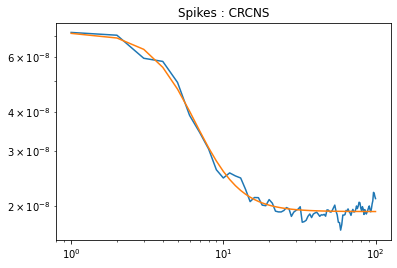

In [8]:
powers = powers_mean[46]
params = fit_lorentzian(freqs[1:], powers[1:])

plt.figure(1)
plt.title('Spikes : CRCNS')
plt.loglog(freqs[1:], powers[1:])
plt.loglog(freqs[1:], 10**lorentzian(freqs[1:], *params));